In [1]:
from faker import Faker
import json
from datetime import datetime, timedelta
import random
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as db

import os
os.chdir('/mnt/c/Users/lipku/Documents/EE3801/Part2')

date_format = "%d/%m/%Y %H:%M:%S"


In [2]:
# Read existing data 
carpark_system_df = pd.read_csv("data/carpark_system.csv", encoding="utf-8-sig")
carpark_system_df.drop(columns="Unnamed: 0", inplace=True)
carpark_system_df.head()

# generate exit data and charging on previous dataset
for index, item in carpark_system_df.iterrows():
    
    if str(item["Exit_DateTime"]) == "" or item["Exit_DateTime"]==None or str(item["Exit_DateTime"]) == "nan":
        days  = 0 # not more than a day
        hours = random.randint(0, 12) # not more than 12 hours
        minutes = random.randint(1, 60)
        seconds = random.randint(1, 60)

        exit_datetime = datetime.strptime(item['Entry_DateTime'], date_format) + timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

        if exit_datetime==None or str(exit_datetime)=='nan':
            carpark_system_df.loc[index, "Exit_DateTime"] = datetime.strptime(item['Entry_DateTime'], date_format) + timedelta(hours=hours, minutes=minutes, seconds=seconds)
        else:
            carpark_system_df.loc[index, "Exit_DateTime"] = exit_datetime.strftime(date_format)

        charged = (exit_datetime - datetime.strptime(item['Entry_DateTime'], date_format)).seconds/60/60/2 * 60/100
        carpark_system_df.loc[index, "Parking_Charges"] = charged


# generate new cars entry and exit

fake=Faker()
fake.license_plate()

class CarPark:
    def __init__(self, Plate, LocationID, Entry_DateTime, Exit_DateTime, Parking_Charges):
        self.Plate = Plate
        self.LocationID = LocationID
        self.Entry_DateTime = Entry_DateTime
        self.Exit_DateTime = Exit_DateTime
        self.Parking_Charges = Parking_Charges

def createNewCarEntryNow():
    # days  = random.randint(1, 60) # 2-3 months
    hours = random.randint(9, 20)
    minutes = random.randint(1, 60)
    seconds = random.randint(1, 60)

    ts = datetime.now() - timedelta(hours=hours, minutes=minutes, seconds=seconds)

    hours = random.randint(0, 9) # not more than 12 hours
    minutes = random.randint(1, 60)
    seconds = random.randint(1, 60)

    duration = timedelta(hours=hours, minutes=minutes, seconds=seconds)
    exit_datetime = ts - duration
    charged = duration.seconds/60/60/2 * 60/100

    car = CarPark(
        Plate= fake.license_plate(),
        LocationID="Park"+str(random.randint(0, 5)),
        Entry_DateTime=ts.strftime(date_format), #.isoformat(),
        Exit_DateTime=exit_datetime.strftime(date_format),
        Parking_Charges=charged
    )

    return json.dumps(car.__dict__) #, sort_keys=True, indent=4)


# Generate more cars, append to list and save csv
carpark_system = []
for i in range(100):
    thiscar_dict = eval(createNewCarEntryNow())
    carpark_system.append(list(thiscar_dict.values()))

new_carpark_system_df = pd.DataFrame(carpark_system, columns=list(eval(createNewCarEntryNow()).keys()))
print("new_carpark_system_df:",len(new_carpark_system_df))
# print(new_carpark_system_df.head())

updated_carpark_system_df = pd.concat([carpark_system_df,new_carpark_system_df], axis=0)
print("updated_carpark_system_df:",len(updated_carpark_system_df))
updated_carpark_system_df.tail()

# export to csv for further analysis
updated_carpark_system_df.to_csv("data/carpark_system.csv", encoding='utf-8-sig')
# export to your OneDrive too for on-demand refresh
updated_carpark_system_df.to_csv("/mnt/c/Users/lipku/OneDrive - National University of Singapore/EE3801/Lab 8/carpark_system.csv", encoding='utf-8-sig')

new_carpark_system_df: 100
updated_carpark_system_df: 2100


In [3]:
!mkdir /mnt/c/Users/lipku/Documents/EE3801/Part2/dev_airflow/dags/data
!pwd

mkdir: cannot create directory ‘/mnt/c/Users/lipku/Documents/EE3801/Part2/dev_airflow/dags/data’: File exists
/mnt/c/Users/lipku/Documents/EE3801/Part2


In [4]:
import pandas as pd
df = pd.read_csv('./data/carpark_system.csv', encoding='utf-8-sig')
df.drop(columns="Unnamed: 0", inplace=True)
df['Entry_DateTime'] = pd.to_datetime(df['Entry_DateTime'],format=date_format)
df['Exit_DateTime'] = pd.to_datetime(df['Exit_DateTime'],format=date_format)
df.head()

,Plate,LocationID,Entry_DateTime,Exit_DateTime,Parking_Charges
0,922 THH,Park4,2024-08-15 21:08:25,2024-08-16 00:36:31,1.040500
1,EWS 428,Park3,2024-08-08 05:06:26,2024-08-08 14:04:49,2.691917
2,8A865,Park3,2024-09-16 23:37:56,2024-09-16 23:51:24,0.067333
3,2OPH 70,Park2,2024-09-03 03:34:45,2024-09-03 13:38:34,3.019083
4,260-XSE,Park3,2024-09-29 20:41:22,2024-09-29 20:47:33,0.030917


In [5]:
# Create database connection
conn_string="dbname='carpark_system' host='localhost' user='airflow' password='airflow'"
conn=db.connect(conn_string)
cur=conn.cursor()

In [6]:
# Check data in table CarPark
query = 'SELECT count(*) FROM public."CarPark Columns"'
cur.execute(query)

# iterate through all the records
for record in cur:
    print(record)

conn.commit()

(1600,)


In [7]:
cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")
tables = cur.fetchall()
print("Tables in public schema:", tables)

Tables in public schema: [('CarPark Columns',)]


In [8]:
# insert one row into database
query = 'INSERT INTO public."CarPark Columns"("Plate", "LocationID", "Entry_DateTime", "Exit_DateTime", "Parking_Charges") VALUES (%s, %s, %s, %s, %s)'
data=tuple(df.iloc[0])
cur.mogrify(query,data)
# execute the query
cur.execute(query,data)


# insert multiple records in a single statement
data = []
query = 'INSERT INTO public."CarPark Columns"("Plate", "LocationID", "Entry_DateTime", "Exit_DateTime", "Parking_Charges") VALUES (%s, %s, %s, %s, %s)'
for index, item in df.iterrows():
    if index > 0:
        data.append(tuple(item))
data_for_db = tuple(data)
cur.mogrify(query,data_for_db[0])
# execute the query
cur.executemany(query,data_for_db)

# make it permanent by committing the transaction
conn.commit()

## What is the top 5 average parking charges for each carpark location?

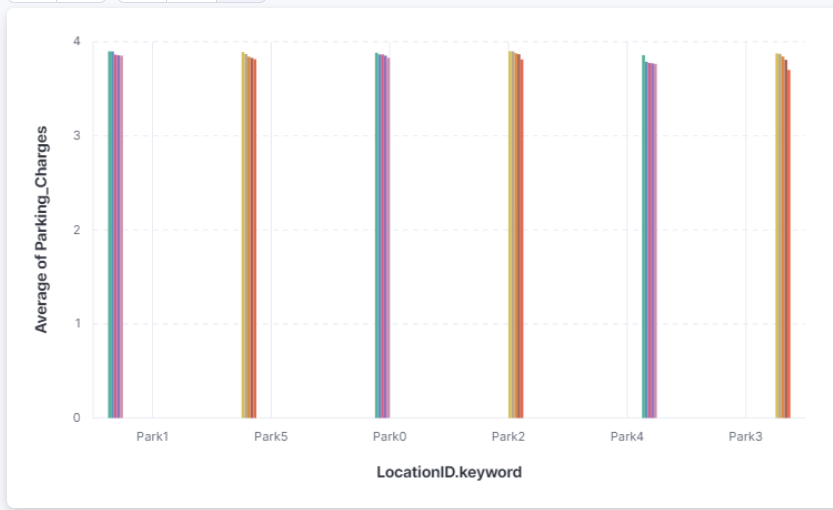

In [9]:
from IPython.display import Image
Image(filename='./image/week8_image26.png')

# Questions to Ponder 

### When do you need to use batch process?

Batch processing is required in the following scenarios:

1. It is essential when we need to process a significant amount of data that cannot be handled efficiently in real time. For example, processing logs, transactions, or large datasets for analysis.
2. Batch processing allows for better resource management since tasks can be run during off-peak hours, minimizing the impact on system performance.
3. When multiple processes or workflows need to be completed in a specific order. Batch processing can handle dependencies and orchestration between these tasks.
4. When we are required to clean, transform, or aggregate data before analysis or storage. Batch processing is able to efficiently apply complex transformations across large datasets.

### Give an example of an application that require batch processing?

An E-Commerce system is an example of an application which requires batch processing. In an e-commerce system, orders are received continuously throughout the day. Instead of processing each order in real-time, which could strain system resources and lead to delays, the system can utilize batch processing by collecting all orders within specific time slots, and then process these orders as a single batch.

### What are the advantages of Airflow batch processing compared to Microsoft Power Apps (MS Excel, MS Sharepoint, MS Power BI)?

Airflow allows users to define complex DAGs that represent workflows. This capability makes it easier to manage dependencies and the execution order of tasks, which is beneficial for complex batch processing scenarios.

Airflow provides robust scheduling capabilities which Microsoft Power Apps do not have, allowing users to run tasks at specific intervals or based on external triggers, improving automation and resource utilization.

Airflow can distribute tasks to different resources and manage execution based on availability, which is particularly useful for resource-intensive batch processes.

Additionally, airflow is primarily Python-based, enabling developers to leverage existing Python libraries and frameworks, which can be more flexible than the formula-based approach in Excel.

### What are the disadvantages?

The disadvantages of Airflow include:
1. Being resource intensive
   - Running an Airflow instance requires significant resources, especially when handling large workloads or many parallel tasks. This can lead to increased infrastructure costs.
2. Database dependency
   - Airflow relies on a metadata database to track tasks and their states, which can become a bottleneck if not properly managed or scaled.
3. Has a limited User Interface
   - While Airflow provides a web-based UI for monitoring and managing workflows, some users find it basic and lacking advanced features compared to dedicated BI tools.
   - The visualization of DAGs and task dependencies may not be as intuitive or visually appealing as other workflow management tools.
4. Not ideal for Real-Time Processing
   - As Airflow is primarily designed for batch processing and scheduled jobs, this makes it less suitable for real-time event processing or immediate task execution

### What level of data maturity in an organisation is more suitable for this application?

Organisations with an intermediate or advanced level of data maturity are most suited to using Apache Airflow. This is because they typically have established data practices, a skilled workforce, and the technical infrastructure necessary to fully utilise Airflow's capabilities. On the other hand, emerging organisations often lack formal data governance and management processes, which can lead to inconsistencies in the data being processed. As Airflow relies on clean, well-structured data to function effectively, an emerging organisation would not be able to fully utilise Airflow. Additionally, as emerging organisations may not have established workflows, it can be challenging to define the DAGs required by Airflow to perform tasks. This can lead to poorly managed processes and inefficiencies, hence organisations with more advanced levels of data maturity are more suited to using Apache Airflow.